# Wizualizacja i inwestygacja danych

In [1]:
import os

import pandas as pd
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from ipywidgets import interact

In [2]:
with open(f"data/5ht7r_7XTC_cleaned.pdb") as ifile:
    system_5ht7r = "".join([x for x in ifile])

with open(f"data/5ht1a_7E2X_cleaned.pdb") as ifile:
    system_5ht1a = "".join([x for x in ifile])
    
with open(f"data/beta2_5D5A_cleaned.pdb") as ifile:
    system_beta2 = "".join([x for x in ifile])
    
with open(f"data/d2_6CM4_cleaned.pdb") as ifile:
    system_d2 = "".join([x for x in ifile])
    
with open(f"data/h1_3RZE_cleaned.pdb") as ifile:
    system_h1 = "".join([x for x in ifile])

Dysponujemy danymi o Ki, które są zawarte w bazie ChEMBL odnośnie 5 celów biologicznych: receptory serotoninowe 5-HT1A i 5-HT7, receptor dopaminowy D2, histaminowy H1 oraz adrenergiczny beta2. W tym notebook'u przedstawiamy analizę wspomnianych danych o Ki, które będą użyte w projekcie

Poniżej znajduje się wizualizacja molekuł receptorów 5-HT1A, 5-HT7, D2, H1, beta2

In [3]:
@interact
def show_protein(target=['5ht7r', '5ht1a', 'beta2', 'd2', 'h1'], style=['balls & sticks', 'cartoon', 'surface']):
    view = py3Dmol.view(width=800, height=500)
    
    if target == '5ht7r':
        system = system_5ht7r
    elif target == '5ht1a':
        system = system_5ht1a
    elif target == 'beta2':
        system = system_beta2
    elif target == 'd2':
        system = system_d2
    else:
        system = system_h1
        
    view.addModelsAsFrames(system)
    
    if style == 'cartoon':
        view.setStyle({'model': -1}, {"cartoon": {'color': 'cyan'}})
    elif style == 'balls & sticks':
        view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
    elif style == 'surface':
        view.setStyle({'model': -1}, {})
        view.addSurface('VDW')

    view.zoomTo({'model': -1})
    view.show()

interactive(children=(Dropdown(description='target', options=('5ht7r', '5ht1a', 'beta2', 'd2', 'h1'), value='5…

Wartość rozpatrywanego parametru aktywności Ki w nadanych nam plikach .sdf kryje się pod polem "Field 11". Zdefiniujmy pomocniczą funkcję dla parsowania plików .sdf i wyciągania potrzebnego parametru

In [13]:
def get_field_11_numbers(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    ki_lines = []
    next_ki = False
    
    for line in lines:
        if '<Field 11>' in line:
            next_ki = True
        elif next_ki:
            ki_lines.append(float(line.rstrip()))
            next_ki = False
    return np.array(ki_lines)

Interpretacja parametru aktywności jest taka, że im mniejsze jego wartości tym związek jest bardziej aktywny. Generalnie przyjmuje się, że Ki poniżej 1000 (jednostką są nM) determinuje aktywność, ale w dalszych badaniach tak naprawdę bierze się pod uwagę związki o aktywności poniżej 100 nM. Dlatego w naszej analizie przyjmujemy "activity_border = 100", czyli będziemy uznawać związki o wartości Ki>100 jako niedostatecznie aktywne, żeby były branę pod uwagę. 

Drugą istotną kwestią jest to, że w badaniach laboratoryjnych nie wyznacza się z reguły dokładnej wartości Ki dla związków nieaktywnych. Dlatego jeśli mamy np wartość Ki = 100 000, to nie znaczy to że rzeczywiście taka wartość została wyznaczona, tylko że w ten sposób zaznacza się nieaktywność związku (przez podanie bardzo dużej wartości Ki). W naszej analizie przyjmujemy "undefined_border=10000", czyli związki o wartości Ki>10000 uznajemy za nieaktywne i za takie , że dla wartość Ki nie była dokładnie obliczana

In [14]:
activity_border=100 
undefined_border=10000

Wczytujemy dane o Ki dla każdego targetu z plików, którymi dysponujemy

In [15]:
ki_5ht7 = get_field_11_numbers('data/files_SDF/5ht7_chembl_Ki_data.sdf')
ki_5ht1a = get_field_11_numbers('data/files_SDF/5ht1a_chembl_Ki_data.sdf')
ki_beta2 = get_field_11_numbers('data/files_SDF/beta2AR_chembl_Ki_data.sdf')
ki_d2 = get_field_11_numbers('data/files_SDF/D2_chembl_Ki_data.sdf')
ki_h1 = get_field_11_numbers('data/files_SDF/H1_chembl_Ki_data.sdf')

proteins_ki = [ki_5ht7, ki_5ht1a, ki_beta2, ki_d2, ki_h1]

## Gęstość wartości Ki

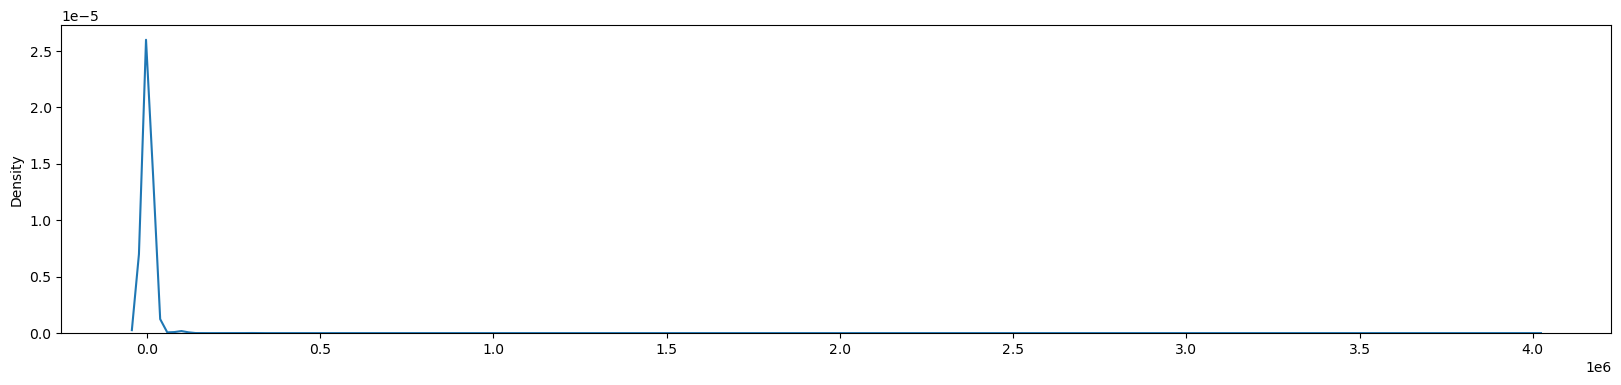

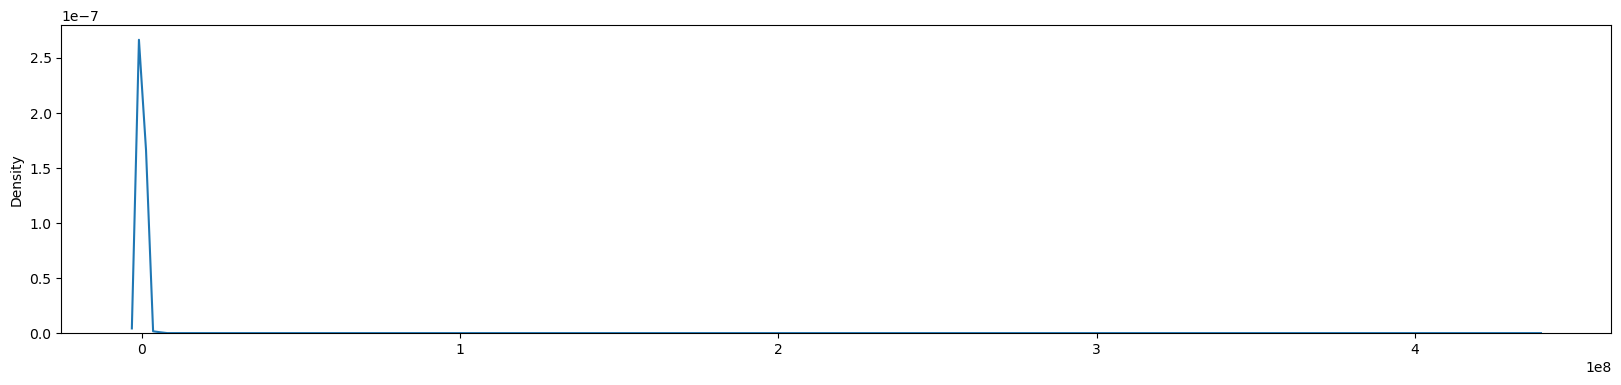

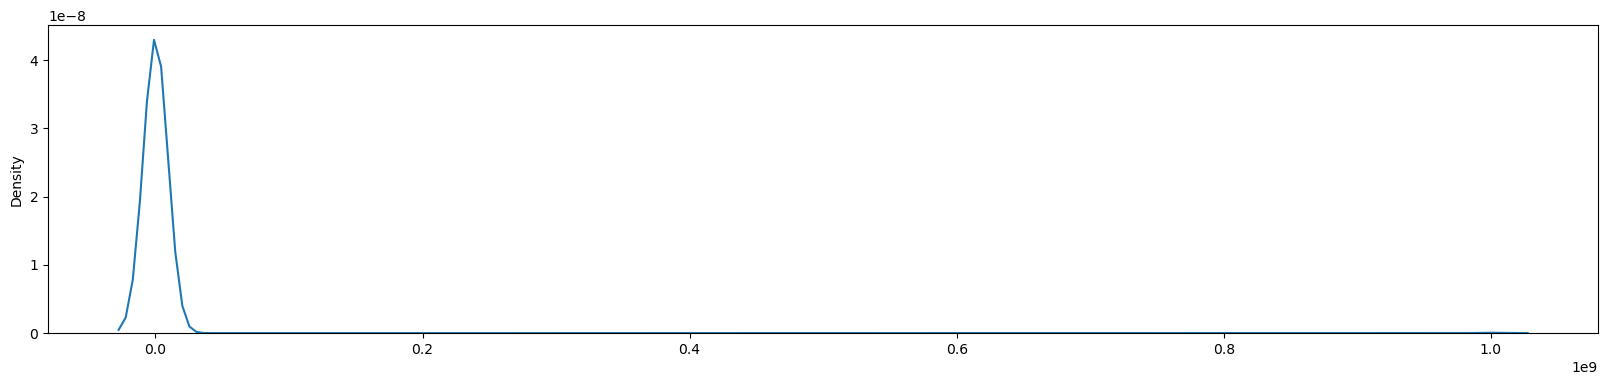

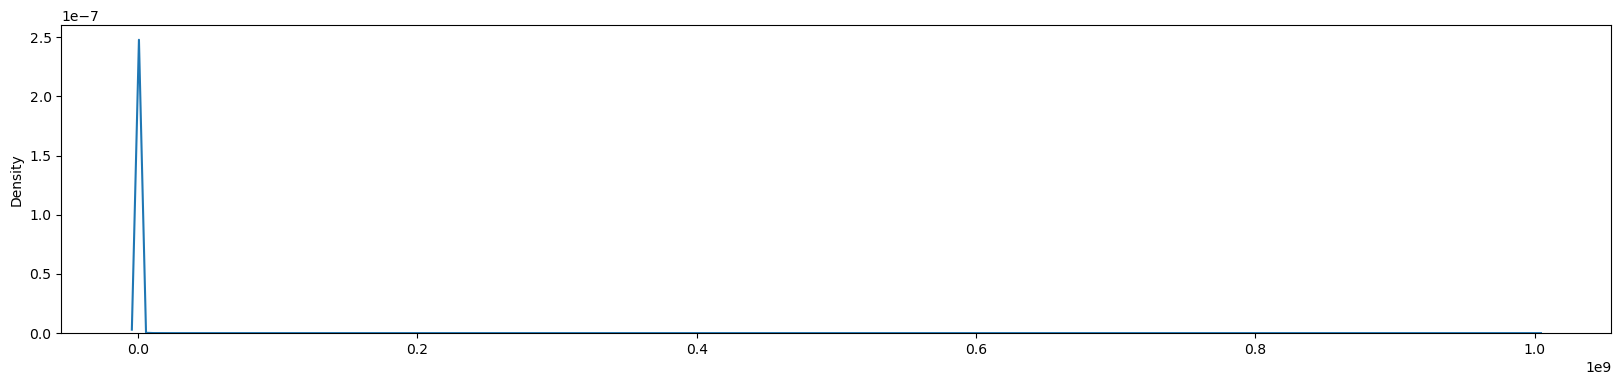

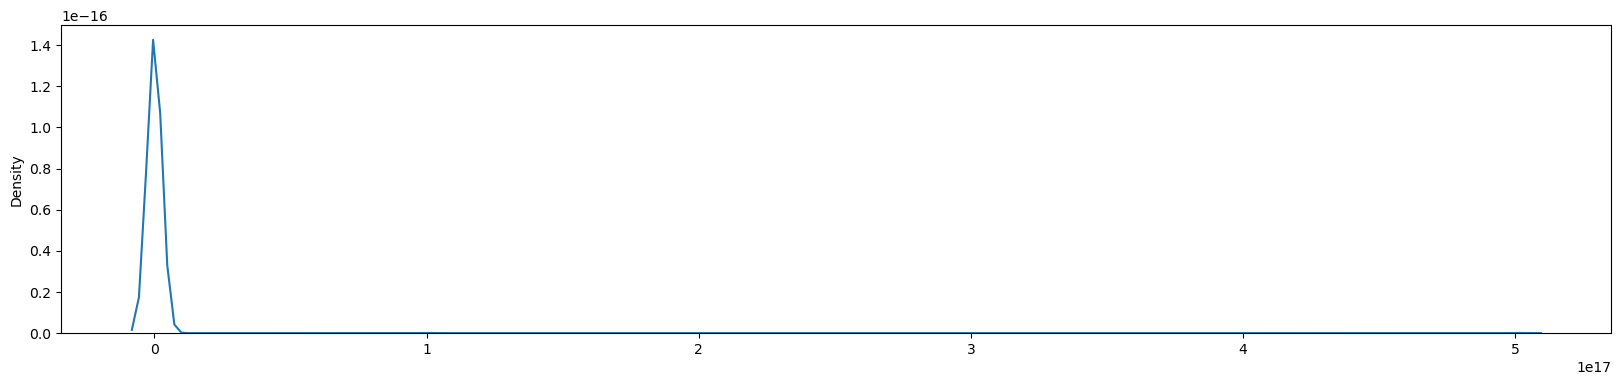

In [16]:
for ki_list in proteins_ki:
    plt.figure(figsize=(20,4))
    sns.kdeplot(ki_list)
    plt.show()

Możemy wyciągnoć wnioski, że absolutna większość wartośći znajduje się w relatywnej bliskości do zera (w naszym przypadku w przedziale od 0 do 1000). Jednak musimy zauważyć, że w każdym przypadku mamy duże ilości wartości odstających, które są bardzo wielkie. Np. 10^6 i 10^8 w przypadku receptorów serotoninowe 5-HT1A i 5-HT7 lub nawet 10^16 w przypadku receptora histaminowego H1.

## Związki aktywne i nieaktywne

Podzielimy związki, którymi dysponujemy na 3 kategorie: <br>
    1. aktywne - o wartości Ki mniejszej od 100 <br>
    2. nieaktywne - o wartości Ki od 100 do 10000 <br>
    3. o niezdefiniowanym Ki (dla których, najprawdopodobniej, podana wartości Ki nie była dokładnie obliczona) - o wartości Ki większej od 10000

Poniżej definiujemy funkcje pomocnicze dla tego celu

In [17]:
def get_active_compounds_ki(coumpounds_ki, activity_border=100):
    return coumpounds_ki[coumpounds_ki<=activity_border]

def get_inactive_compounds_ki(coumpounds_ki, activity_border=100, undefined_border=10000):
    return coumpounds_ki[np.logical_and((coumpounds_ki > activity_border), (coumpounds_ki<undefined_border))]

def get_undefined_compounds_ki(coumpounds_ki, undefined_border=10000):
    return coumpounds_ki[coumpounds_ki>=undefined_border]

def get_number_of_active_compounds(coumpounds_ki, activity_border=100, undefined_border=10000):
    count_active = get_active_compounds_ki(coumpounds_ki, activity_border).size
    count_inactive = get_inactive_compounds_ki(coumpounds_ki, activity_border, undefined_border).size
    count_undefined = get_undefined_compounds_ki(coumpounds_ki, undefined_border).size
    
    return {'active': count_active, 'inactive': count_inactive, '>=10000 nM': count_undefined}

def plot_activity_data(activity_data):
    colors=['olivedrab', 'brown', 'slategray']
    
    x_data = ['active', 'inactive', '>=10000 nM']
    y_data = [activity_data['active'], activity_data['inactive'], activity_data['>=10000 nM']]
    
    plt.bar(x_data, y_data, color = colors)
    plt.xlabel('Value')
    plt.ylabel('Count')

##### Podział na kategorie danych o aktywności związków do receptora serotoninowego 5-HT7

{'active': 1695, 'inactive': 1224, '>=10000 nM': 220}


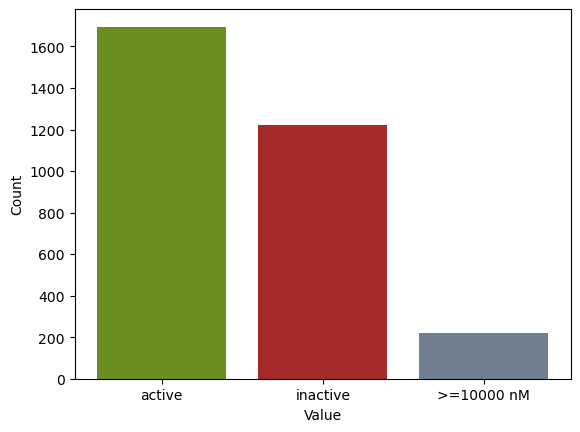

In [18]:
plot_activity_data(get_number_of_active_compounds(ki_5ht7))
print(get_number_of_active_compounds(ki_5ht7))

##### Podział na kategorie danych o aktywności związków do receptora serotoninowego 5-HT1A

{'active': 3314, 'inactive': 2074, '>=10000 nM': 242}


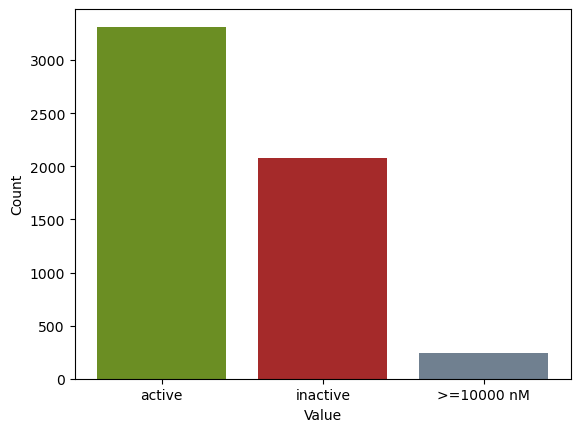

In [19]:
plot_activity_data(get_number_of_active_compounds(ki_5ht1a))
print(get_number_of_active_compounds(ki_5ht1a))

##### Podział na kategorie danych o aktywności związków do receptora adrenergicznego beta2

{'active': 349, 'inactive': 272, '>=10000 nM': 190}


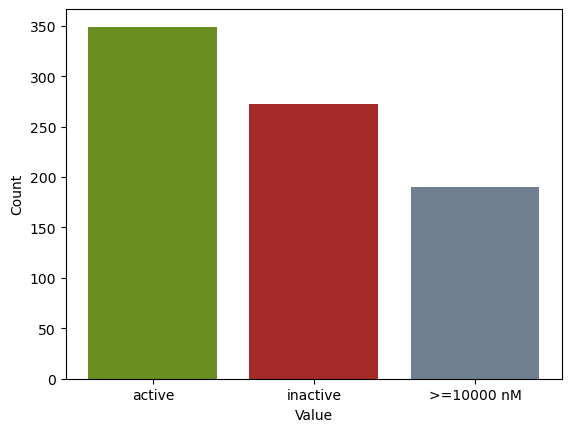

In [20]:
plot_activity_data(get_number_of_active_compounds(ki_beta2))
print(get_number_of_active_compounds(ki_beta2))

##### Podział na kategorie danych o aktywności związków do receptora dopaminowego D2

{'active': 4048, 'inactive': 5816, '>=10000 nM': 886}


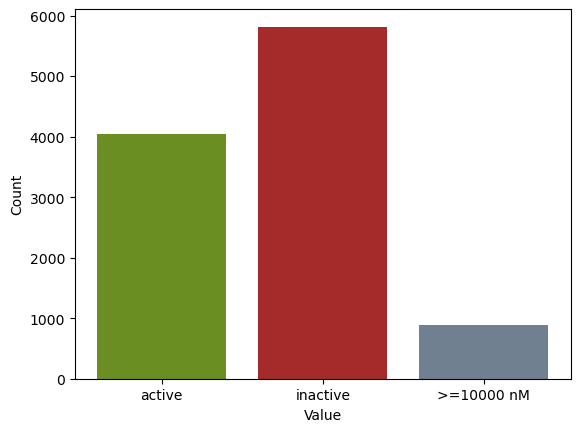

In [21]:
plot_activity_data(get_number_of_active_compounds(ki_d2))
print(get_number_of_active_compounds(ki_d2))

##### Podział na kategorie danych o aktywności związków do receptora histaminowego H1

{'active': 690, 'inactive': 781, '>=10000 nM': 270}


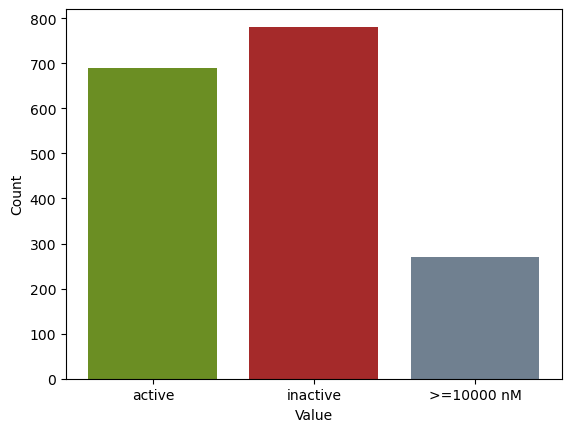

In [22]:
plot_activity_data(get_number_of_active_compounds(ki_h1))
print(get_number_of_active_compounds(ki_h1))

Możemy wyciągnąć następujące wnioski: <br>
- związki są rozdzielone na aktywne-nieaktywne w miarę równolicznie, z tym że nieaktywnych związków (o wartości Ki > 100) jest akceptowalnie więcej
- możemy mieć problem z niedostateczną ilością otargetowanych danych. W takim przypadku można będzie skorzystać z bazy ChEMBL i pobrać dane o aktywnościach jeszcze kilku targetów

## Dystrybucja wartości Ki

##### Dystrybucja wartości Ki dla związków aktywnych do receptora serotoninowego 5-HT7

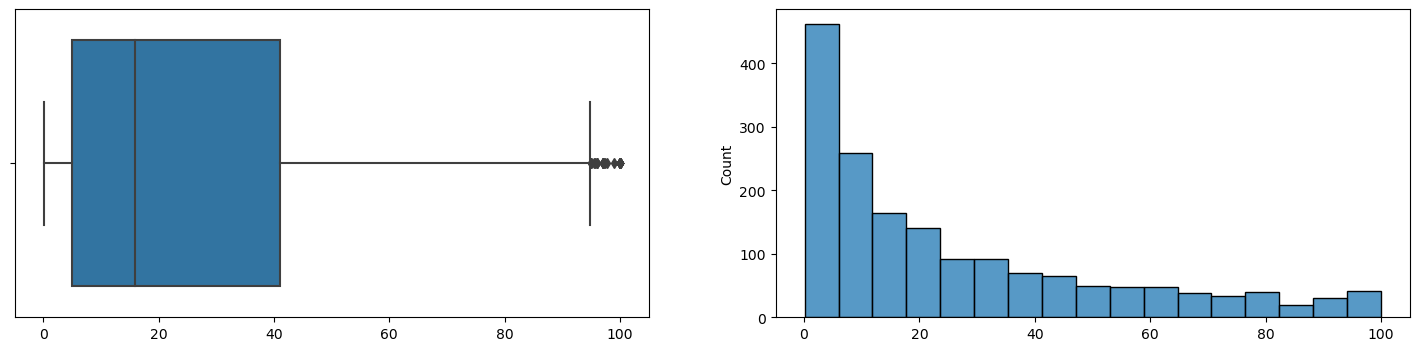

In [23]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_active_compounds_ki(ki_5ht7))
plt.subplot(1,2,2)
sns.histplot(x=get_active_compounds_ki(ki_5ht7))
plt.show()

##### Dystrybucja wartości Ki dla związków aktywnych do receptora serotoninowego 5-HT1A

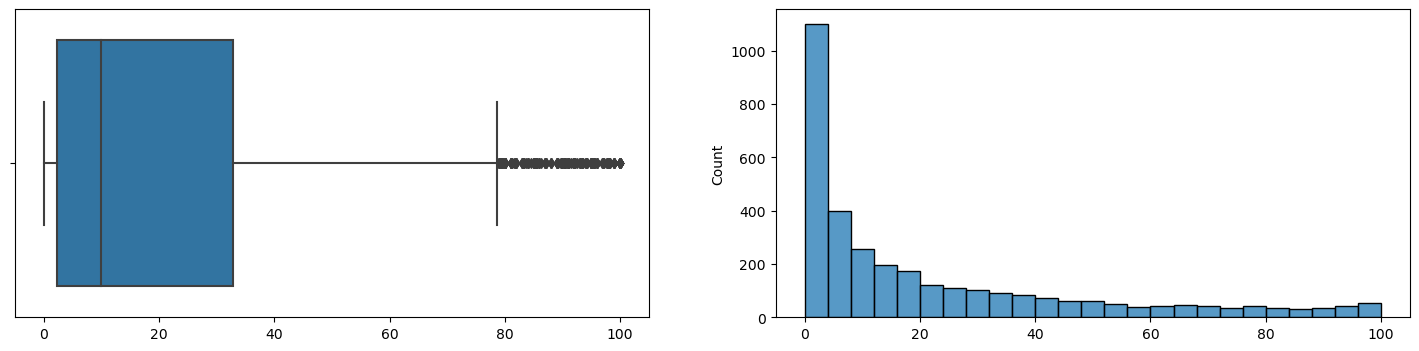

In [24]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_active_compounds_ki(ki_5ht1a))
plt.subplot(1,2,2)
sns.histplot(x=get_active_compounds_ki(ki_5ht1a))
plt.show()

##### Dystrybucja wartości Ki dla związków aktywnych do receptora adrenergicznego beta2

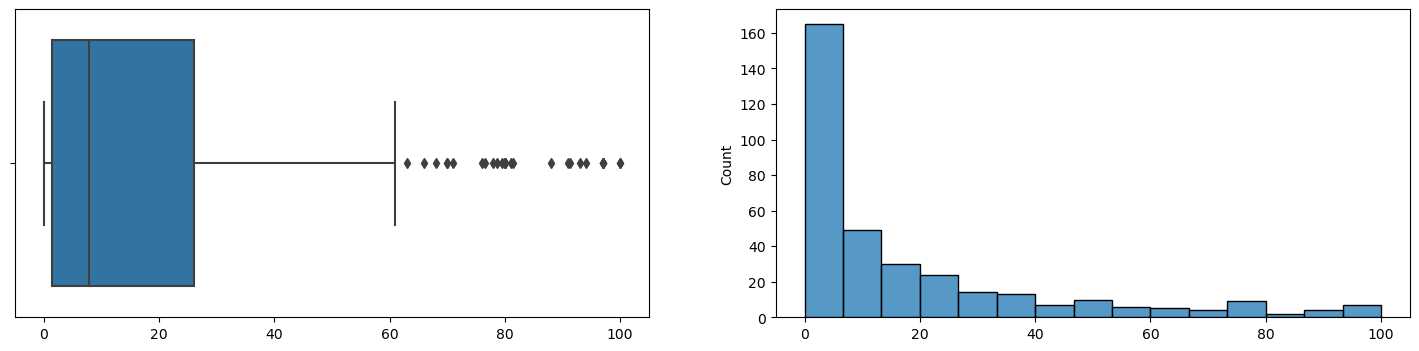

In [25]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_active_compounds_ki(ki_beta2))
plt.subplot(1,2,2)
sns.histplot(x=get_active_compounds_ki(ki_beta2))
plt.show()

##### Dystrybucja wartości Ki dla związków aktywnych do receptora dopaminowego D2

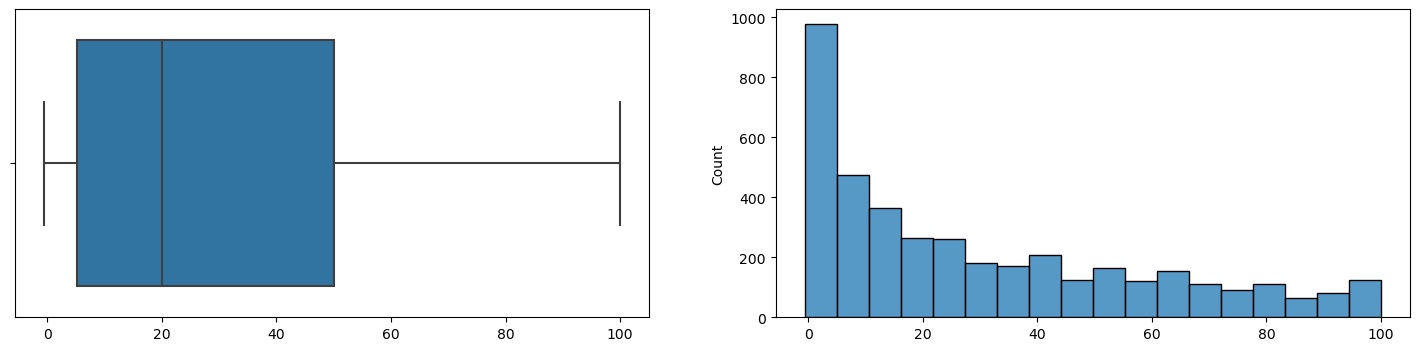

In [26]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_active_compounds_ki(ki_d2))
plt.subplot(1,2,2)
sns.histplot(x=get_active_compounds_ki(ki_d2))
plt.show()

##### Dystrybucja wartości Ki dla związków aktywnych do receptora histaminowego H1

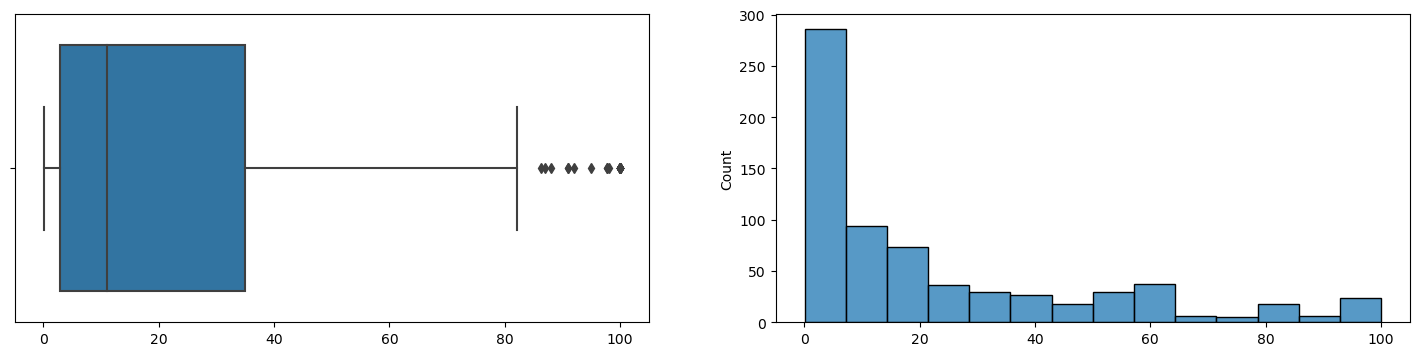

In [27]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_active_compounds_ki(ki_h1))
plt.subplot(1,2,2)
sns.histplot(x=get_active_compounds_ki(ki_h1))
plt.show()

##### Dystrybucja wartości Ki dla związków nieaktywnych do receptora serotoninowego 5-HT7

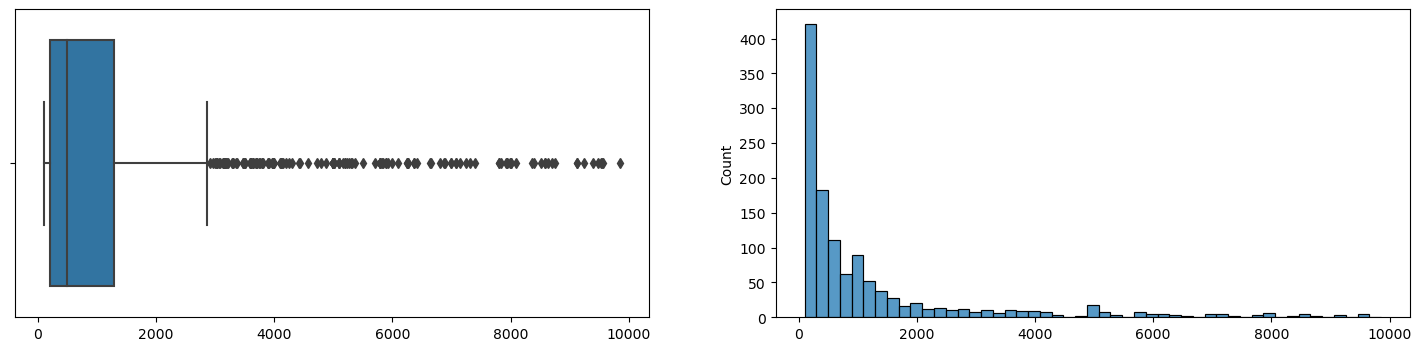

In [28]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_inactive_compounds_ki(ki_5ht7))
plt.subplot(1,2,2)
sns.histplot(x=get_inactive_compounds_ki(ki_5ht7))
plt.show()

##### Dystrybucja wartości Ki dla związków nieaktywnych do receptora serotoninowego 5-HT1A

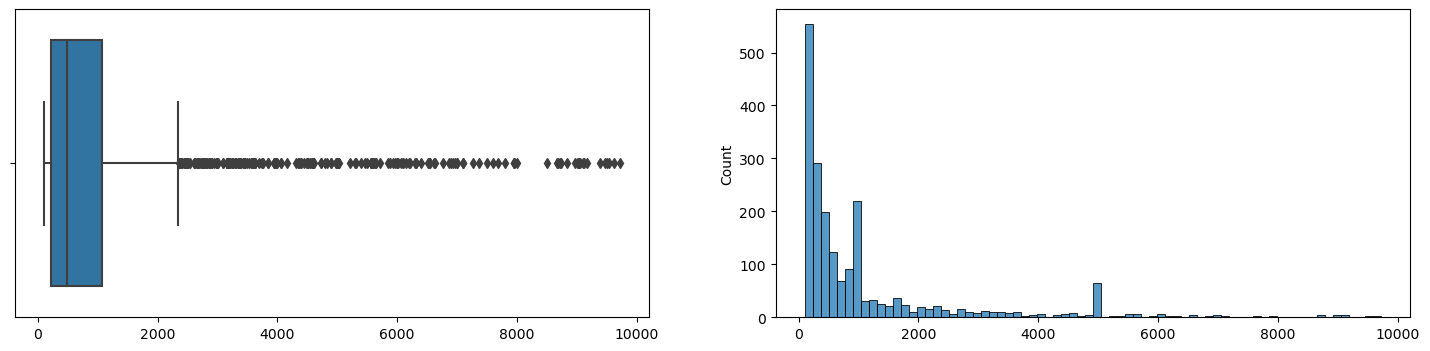

In [29]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_inactive_compounds_ki(ki_5ht1a))
plt.subplot(1,2,2)
sns.histplot(x=get_inactive_compounds_ki(ki_5ht1a))
plt.show()

##### Dystrybucja wartości Ki dla związków nieaktywnych do receptora adrenergicznego beta2

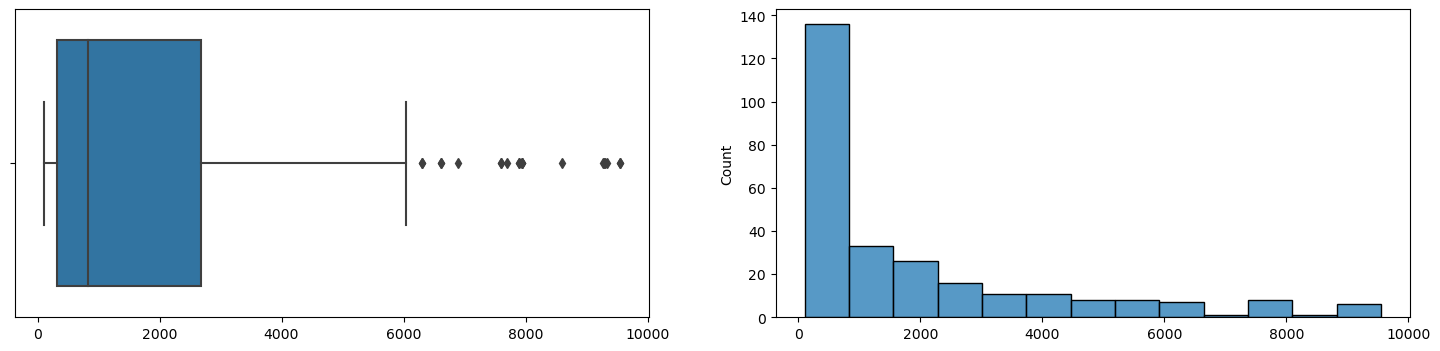

In [30]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_inactive_compounds_ki(ki_beta2))
plt.subplot(1,2,2)
sns.histplot(x=get_inactive_compounds_ki(ki_beta2))
plt.show()

##### Dystrybucja wartości Ki dla związków nieaktywnych do receptora dopaminowego D2

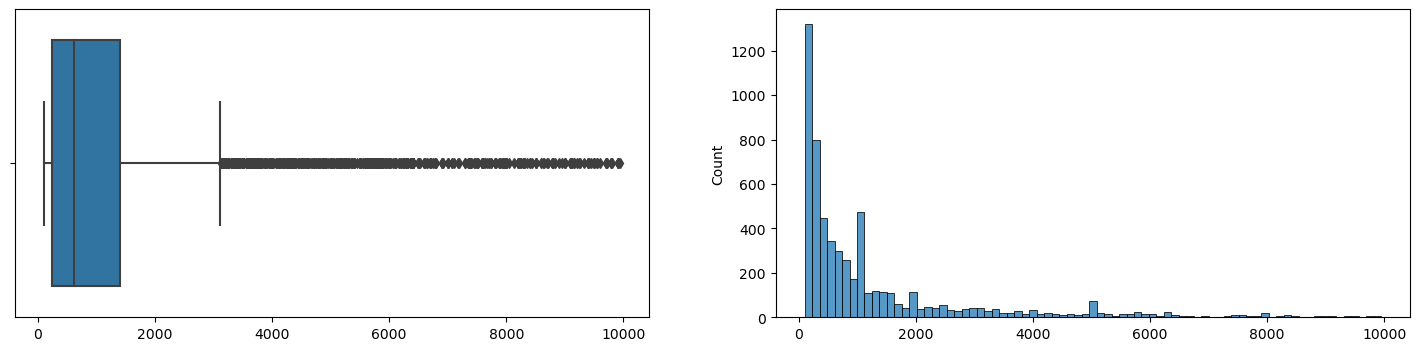

In [31]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_inactive_compounds_ki(ki_d2))
plt.subplot(1,2,2)
sns.histplot(x=get_inactive_compounds_ki(ki_d2))
plt.show()

##### Dystrybucja wartości Ki dla związków nieaktywnych do receptora histaminowego H1

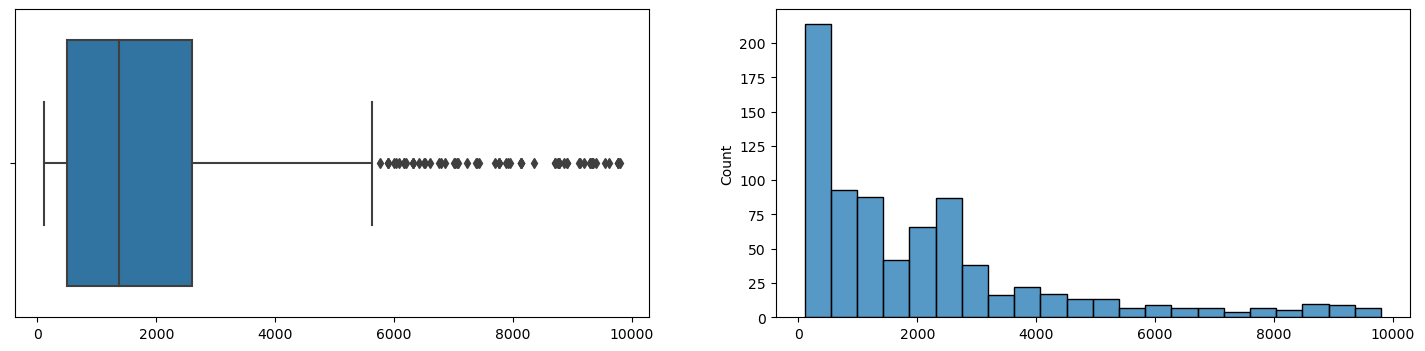

In [32]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.boxplot(x=get_inactive_compounds_ki(ki_h1))
plt.subplot(1,2,2)
sns.histplot(x=get_inactive_compounds_ki(ki_h1))
plt.show()

## Unikalność danych

W tej części zbadamy ile związków powtarza się w kolejnych plikach z aktywnościami. Oraz wyliczymy, dane o ilu unikalnych zwiąków posiadamy.

Zdefiniujmy funkcje pomocznicze. Będziemy rozróżniać związki przy pomocy id przypidanego im w bazie ChEMBL, które kryje się pod polem 1

In [42]:
def get_field_1_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    id_lines = []
    next_id = False
    
    for line in lines:
        if '<Field 1>' in line:
            next_id = True
        elif next_id:
            id_lines.append(line.rstrip())
            next_id = False
    return np.array(id_lines)

def count_common_elements(arr1, arr2):
    set1 = set(arr1)
    set2 = set(arr2)
    
    common_elements = set1.intersection(set2)
    count = len(common_elements)
    
    return count

Wczytamy id związków z plików

In [45]:
ids_5ht7 = get_field_1_data('data/files_SDF/5ht7_chembl_Ki_data.sdf')
ids_5ht1a = get_field_1_data('data/files_SDF/5ht1a_chembl_Ki_data.sdf')
ids_beta2 = get_field_1_data('data/files_SDF/beta2AR_chembl_Ki_data.sdf')
ids_d2 = get_field_1_data('data/files_SDF/D2_chembl_Ki_data.sdf')
ids_h1 = get_field_1_data('data/files_SDF/H1_chembl_Ki_data.sdf')

targets_ids = [ids_5ht7, ids_5ht1a, ids_beta2, ids_d2, ids_h1]
targets     = ['5ht7', '5ht1a', 'beta2', 'd2', 'h1']

In [59]:
def plot_commons_data(arr):
    colors=['olivedrab', 'brown', 'teal', 'indigo', 'chocolate']
    
    x_data = targets
    y_data = []
    
    for ids in targets_ids:
        y_data.append(count_common_elements(arr, ids)/len(set(ids)) * 100)
    
    plt.bar(x_data, y_data, color = colors)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.ylim(0, 100)
    
    plt.show()

Wykres skałada się z 5 kolumn, każda reprezentuje jeden target. Wartościreprezentowane przez kolumny to procent powtórzonych związków. Jezeli kolumna ma wartość 100, to znaczy że badamy ile związków z danych o aktywnościach dla tego targetu powtórzyło się w danych dla innych targetów. Wtedy inne kolumny reprezentują ile procent związków z danych dla tych celi biologicznych, powtarzają się w danych dla celu, którego wartość jest 100. 

##### Powtórzenia z danych o aktywnościach dla receptora serotoninowego 5-HT7

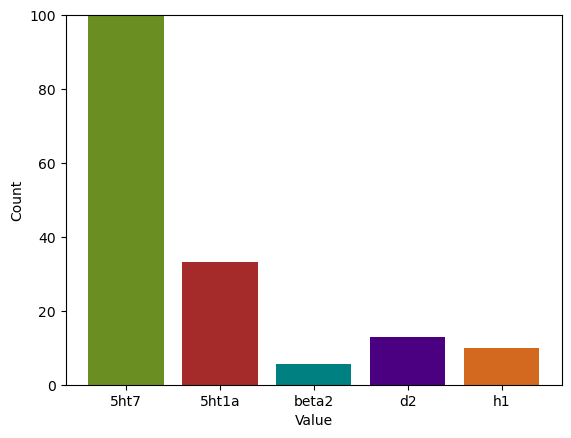

In [62]:
plot_commons_data(ids_5ht7)

##### Powtórzenia z danych o aktywnościach dla receptora serotoninowego 5-HT1A

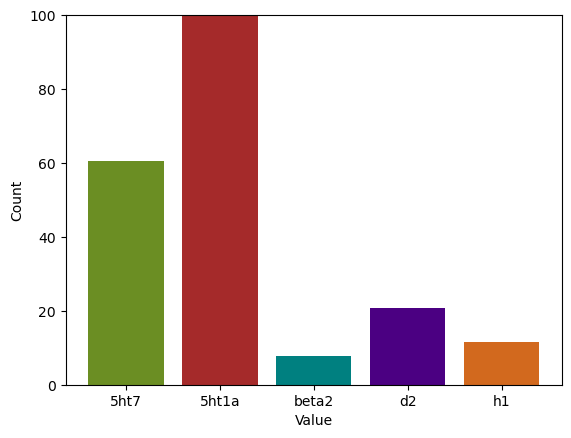

In [63]:
plot_commons_data(ids_5ht1a)

##### Powtórzenia z danych o aktywnościach dla receptora adrenergicznego beta2

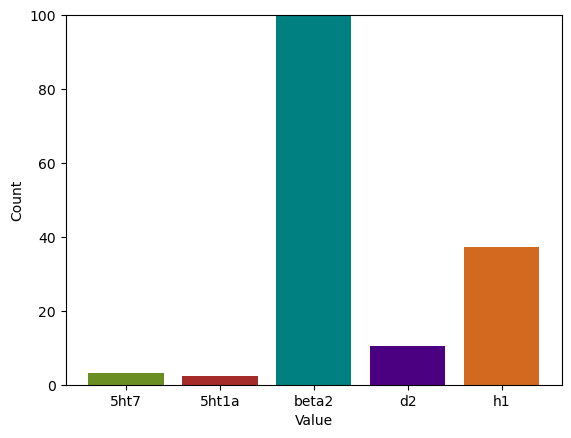

In [64]:
plot_commons_data(ids_beta2)

##### Powtórzenia z danych o aktywnościach dla receptora dopaminowego D2

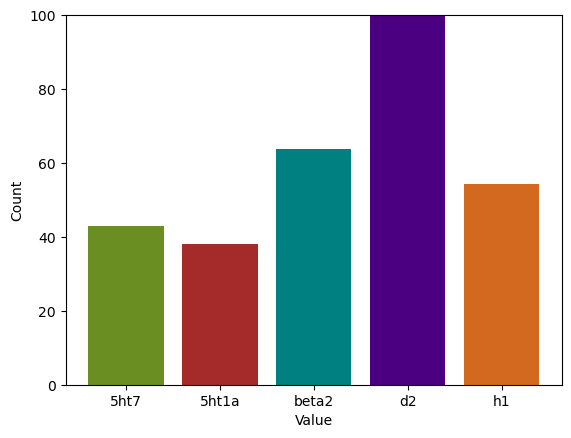

In [65]:
plot_commons_data(ids_d2)

##### Powtórzenia z danych o aktywnościach dla receptora histaminowego H1

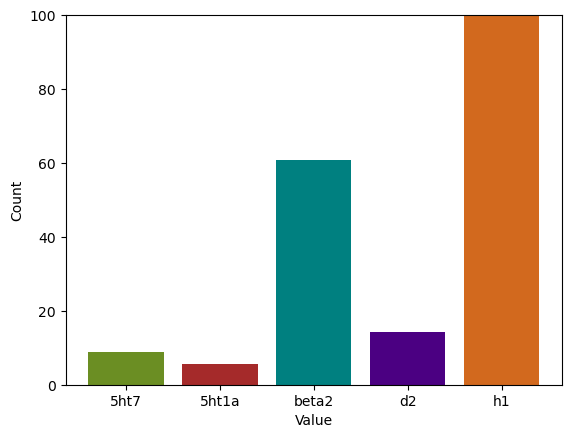

In [66]:
plot_commons_data(ids_h1)

In [71]:
all_ids = np.concatenate((ids_5ht7, ids_5ht1a, ids_beta2, ids_d2, ids_h1))
all_unique_ids = set(all_ids)
print("Ilość wszystkich związków = ", all_ids.size)
print("Ilość unikalnych związków = ", len(all_unique_ids))

Ilość wszystkich związków =  25215
Ilość unikalnych związków = 14488


Widzimy że dość duża ilość związków jest powtarzalna, to trzaba brać pod uwagę podczas realizacji projektu. Dysponujemy wyłącznie 14488 otargetowanymi związkami 

Ponadto podczas analizy zostało zauważone że dane o aktywnościach niektórych zdublikowanych w obrębie jednego pliku związków różnią się. To może stwarzać niepotrzebne problemy dla MLowej części algorytmu generowania. Lub na odwrót wproeadzać potrzebny szum. W każdym razie, trzeba mieć to na uwadze.

Na poniższym wykresie przedstawiamy procent zdublikowanych związków w obrębie jednego pliku z danymi dla konkretnego celu biologicznego

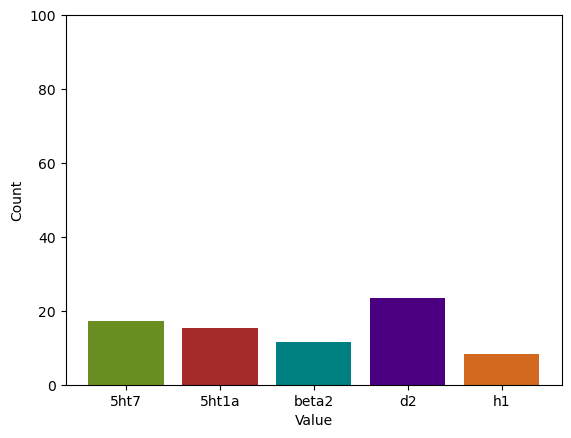

In [79]:
colors=['olivedrab', 'brown', 'teal', 'indigo', 'chocolate']

x_data = targets
y_data = []
    
for ids in targets_ids:
    y_data.append(100 - len(set(ids))/ids.size * 100)
    
plt.bar(x_data, y_data, color = colors)
plt.xlabel('Value')
plt.ylabel('Count')
plt.ylim(0, 100)
    
plt.show()

Sugerowalibyśmy odfiltrować zdublikowane instancje związków, które mają tą samą wartość Ki

## Wnioski

1. Absolutna większość wartośći Ki w naszych danych znajduje się w relatywnej bliskości do zera. Jednak w przypadku każdego targeta mamy duże ilości wartości odstających.
2. Rozkład danych Ki przypomina rozkład Rayleigha.
3. Związki są rozdzielone na aktywne-nieaktywne w miarę równolicznie
4. Około 15% związków znajdujących się w danych dla jednego targetu dublikuje się w danych dla innych 4 targetów.
5. Informacja o jednym i tym samym związki może być dublikowana w jednym i tym samym pliku. Ponadto podczas dane o aktywnościach niektórych zdublikowanych w obrębie jednego pliku związków różnią się.

